In [1]:
import numpy as np
#
# The function in this file follow closely after the MATLAB scripts
# written by Alessandro Foi and Markku Makitalo - Tampere University
# of Technology - 2011-2012
#
#    http://www.cs.tut.fi/~foi/invansc/
#
# that accompanies their paper:
#
#    Reference: M. Makitalo and A. Foi, "Optimal inversion of the
#    generalized Anscombe transformation for Poisson-Gaussian noise",
#    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675


#-------- Variance stabilizing transforms -----------

def anscombe(x):
    '''
    Compute the anscombe variance stabilizing transform.
      the input   x   is noisy Poisson-distributed data
      the output  fx  has variance approximately equal to 1.
    Reference: Anscombe, F. J. (1948), "The transformation of Poisson,
    binomial and negative-binomial data", Biometrika 35 (3-4): 246-254
    '''
    return 2.0*np.sqrt(x + 3.0/8.0)

def inverse_anscombe(z):
    '''
    Compute the inverse transform using an approximation of the exact
    unbiased inverse.
    Reference: Makitalo, M., & Foi, A. (2011). A closed-form
    approximation of the exact unbiased inverse of the Anscombe
    variance-stabilizing transformation. Image Processing.
    '''
    #return (z/2.0)**2 - 3.0/8.0
    return (1.0/4.0 * np.power(z, 2) +
            1.0/4.0 * np.sqrt(3.0/2.0) * np.power(z, -1.0) -
            11.0/8.0 * np.power(z, -2.0) + 
            5.0/8.0 * np.sqrt(3.0/2.0) * np.power(z, -3.0) - 1.0 / 8.0)

def generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Compute the generalized anscombe variance stabilizing transform,
    which assumes that the data provided to it is a mixture of poisson
    and gaussian noise.
    The input signal  z  is assumed to follow the Poisson-Gaussian noise model
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    We assume that x contains only positive values.  Values that are
    less than or equal to 0 are ignored by the transform.
    Note, this transform will show some bias for counts less than
    about 20.
    '''
    y = gain*x + (gain**2)*3.0/8.0 + sigma**2 - gain*mu

    # Clamp to zero before taking the square root.
    return (2.0/gain)*np.sqrt(np.maximum(y, 0.0))

def inverse_generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Applies the closed-form approximation of the exact unbiased
    inverse of Generalized Anscombe variance-stabilizing
    transformation.
    The input signal x is transform back into a Poisson random variable
    based on the assumption that the original signal from which it was
    derived follows the Poisson-Gaussian noise model:
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    Roference: M. Makitalo and A. Foi, "Optimal inversion of the
    generalized Anscombe transformation for Poisson-Gaussian noise",
    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675
    '''
    test = np.maximum(x, 1.0)
    exact_inverse = ( np.power(test/2.0, 2.0) +
                      1.0/4.0 * np.sqrt(3.0/2.0)*np.power(test, -1.0) -
                      11.0/8.0 * np.power(test, -2.0) +
                      5.0/8.0 * np.sqrt(3.0/2.0) * np.power(test, -3.0) -
                      1.0/8.0 - np.power(sigma, 2) )
    exact_inverse = np.maximum(0.0, exact_inverse)
    exact_inverse *= gain
    exact_inverse += mu
    exact_inverse[np.where(exact_inverse != exact_inverse)] = 0.0
    return exact_inverse

#def inverse_generalized_anscombe(y,mu,sigma,gain=1.0):
#    return (1.0/gain)*(gain*y/2.0)**2 - gain*3.0/8.0 - (sigma**2)/gain + mu

In [2]:
from bm3d import bm3d, BM3DProfile
import numpy as np
import scipy.misc
from matplotlib import pyplot as plt
from tifffile import imread, imsave

In [3]:
noisy = imread('../../../experiments/fairSim/2020-07-27/Zeiss/p1/Zeiss_Mito_600nm_crop_Poisson-n1.tif').astype(np.float32)

clean = imread('../../../experiments/fairSim/2020-07-27/Zeiss/Zeiss_Mito_600nm_crop.tif').astype(np.float32)
print(noisy.shape)
print(clean.shape)


(5, 25, 512, 512)
(5, 25, 512, 512)


In [4]:
offset=100
from tqdm import tqdm
mses=[]
denoisedImgs=[]
bestMSE = None
bestImg = None
bestSig= None

for s in range(40):
    sig = (s+1)*2.5
    #denoised=noisy.copy()
    j=0
    #for i in range(5):
    i=0
#        print(i,j)

    img=noisy[i,j,...]
    cl= clean[i,j,...]

        
    ans=anscombe(img-offset)
    denoised = inverse_anscombe (bm3d (ans,sig)) + offset
    
        
    mse = np.mean((cl-denoised)**2)
    mses.append(mse)
    denoisedImgs.append(denoised.copy())
    
    if bestMSE is None or (mse<bestMSE):
        bestImg = denoised.copy()
        bestMSE = mse
        bestSig = sig
    print (sig, bestSig, mse)

        

2.5 2.5 10238.714729152069
5.0 5.0 2641.589642544416
7.5 7.5 2462.6189377405744
10.0 7.5 2603.879002346505
12.5 7.5 2805.0260300935306
15.0 7.5 3046.4012868065915
17.5 7.5 3314.004815334095
20.0 7.5 3602.995246388291
22.5 7.5 3894.071349645799
25.0 7.5 4178.142284655731
27.5 7.5 4469.883414113896
30.0 7.5 4757.848001832396
32.5 7.5 5040.925379218681
35.0 7.5 5335.900903137947
37.5 7.5 5623.875471045293
40.0 7.5 5912.0885116194395
42.5 7.5 6201.766244946316
45.0 7.5 6479.8863627976525
47.5 7.5 6756.14241451605
50.0 7.5 7014.303574811258
52.5 7.5 7275.550960052647
55.0 7.5 7529.405337486758
57.5 7.5 7778.255451779653
60.0 7.5 8014.51558470714
62.5 7.5 8244.358654929876
65.0 7.5 8463.862208532048
67.5 7.5 8682.141641808717
70.0 7.5 8893.660009307583
72.5 7.5 9104.469800114866
75.0 7.5 9317.07449118946
77.5 7.5 9518.658746425823
80.0 7.5 9716.982021154094
82.5 7.5 9917.271055894344
85.0 7.5 10116.05010788699
87.5 7.5 10314.270521221752
90.0 7.5 10513.534044263286
92.5 7.5 10714.88062385096

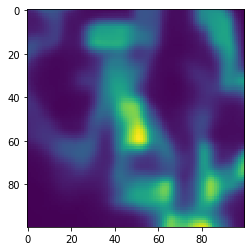

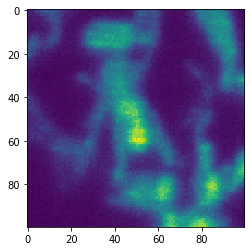

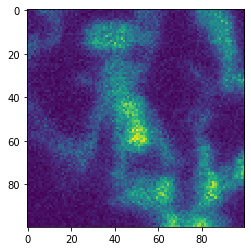

In [5]:
plt.imshow(denoisedImgs[11][100:200,100:200])
plt.show()
plt.imshow(cl[100:200,100:200])
plt.show()
plt.imshow(img[100:200,100:200])


In [6]:
offset=100
from tqdm import tqdm
denoised=noisy.copy()

for j in tqdm(range(25)):
    for i in range(5):
        img=noisy[i,j,...]
        cl= clean[i,j,...]

        sig = bestSig

        ans=anscombe(img-offset)
        denoisedImg = inverse_anscombe (bm3d (ans,sig)) + offset
        denoised[i,j,...] = denoisedImg
    


imsave('../../../experiments/fairSim/2020-07-27/Zeiss/p1/n1_VST-BM3D.tif', denoised)
        

100%|██████████| 25/25 [1:04:03<00:00, 153.74s/it]
